```{currentmodule} tskit
```

(sec_args)=

# _ARGs as tree sequences_
% remove underscores in title when tutorial is complete or near-complete

:::{note}
This tutorial is a work in progress.
:::

At its heart, a `tskit` {ref}`tree sequence<sec_what_is>` consists of a list of
{ref}`sec_terminology_nodes`, and a list of {ref}`sec_terminology_edges` that connect
those nodes. Therefore a succinct tree sequence is equivalent to a
[mathematical graph](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)),
which is additionally annotated with genomic positions such that at each
position, a path through the edges exists which defines a tree. This graph
interpretation of a tree sequence is tightly connected to the concept of
an "ancestral recombination graph" (or ARG). 

:::{margin}
An original, narrower definition, which we do not use here, restricts the term ARG to
the neutral coalescent process with crossover-recombination, and the graph structure
defined by that process, see e.g.
[Griffiths & Marjoram (1997)](https://research.monash.edu/en/publications/an-ancestral-recombination-graph)
:::
The term "ARG" is [often used](https://doi.org/10.1086%2F508901) to refer to
a structure consisting of nodes and edges that describe the genetic genealogy of a set
of sampled chromosomes which have evolved via a process of genetic inheritance combined
with recombination. ARGs may contain not just nodes corresponding to genetic
coalescence, but also additional nodes that correspond e.g. to recombination events
(see {ref}`sec_args_arg_nodes`, below). We call these "full ARGs", and this tutorial aims
to show you how [tskit](https://tskit.dev) can be used to store and analyse them.
As an example, we will generate a full ARG using the process 
{func}`msprime:msprime.sim_ancestry` with the `record_full_arg=True` option, as described
{ref}`in the msprime docs<msprime:sec_ancestry_full_arg>`:

In [1]:
import msprime

parameters = {
    "samples": 3, # Three diploid individuals == six sample genomes
    "sequence_length": 1e4,
    "recombination_rate": 1e-7,
    "population_size": 1e3,
    "random_seed": 333,
}

ts_arg = msprime.sim_ancestry(**parameters, record_full_arg=True, discrete_genome=False)
# NB: the strict Hudson ARG needs unique crossover positions (i.e. a continuous genome)

print('"Full ARG" simulated under the Hudson model:')
print(
    f" stored in a tree sequence with {ts_arg.num_nodes} nodes and "
    f" {ts_arg.num_edges} edges which form {ts_arg.num_trees} local trees"
)

"Full ARG" simulated under the Hudson model:
 stored in a tree sequence with 17 nodes and  18 edges which form 3 local trees


Like any tree sequence, we can also add mutations to the ARG to generate genetic
variation:

In [2]:
import numpy as np
mu = 1e-7
ts_arg = msprime.sim_mutations(ts_arg, rate=mu, random_seed=888)
print("     Sample node:  " + "   ".join(str(u) for u in ts_arg.samples()))
for v in ts_arg.variants():
    print(f"Variable site {v.site.id}:", np.array(v.alleles)[v.genotypes])

     Sample node:  0   1   2   3   4   5
Variable site 0: ['T' 'C' 'T' 'C' 'C' 'C']
Variable site 1: ['C' 'C' 'C' 'C' 'G' 'C']
Variable site 2: ['T' 'T' 'G' 'T' 'T' 'T']


As well as the standard {ref}`sec_tskit_viz` of the tree sequence as a set of local
trees, we can also
{ref}`plot this tree sequence in network form<sec_tskit_viz_other_graph>`:

:::{todo}
Incorporate something into [tsviz](https://github.com/tskit-dev/tsviz)
like the `draw` function from
https://github.com/tskit-dev/what-is-an-arg-paper/blob/main/argutils/viz.py, and
use that to plot a graph-based viz of this ts, e.g.
```{code}
import argutils
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
ts2 = argutils.viz.label_nodes(ts_arg)
_ = argutils.draw(ts_arg, ax, draw_edge_widths=True)
```
![Example ARG view](_static/ARG.png)

(this PNG file can be removed once the code to autogenerate it is incorporated)
:::

## Background semantics

Two features distinguish the genealogical structure stored in a `tskit` tree sequence
from many other ARG formats. Firstly, the annotations that define which genomic regions
are inherited are stored on *edges* (via the {attr}`~Edge.left` and a {attr}`~Edge.right`
properties), rather than on the graph nodes, as is sometimes the case. Secondly, the
nodes in a tree sequence correspond to *genomes*, rather that specific events such as
coalescence or recombination.

Technically therefore, ARGs stored by `tskit` are edge-annotated
"genome ARGs" (gARGs). This results in a flexible format that can describe
ancestral graphs created by many biological processes, including ones that deviate from
the neutral coalescent-with-recombination (CwR), for example ancestries incorporating
gene conversion, or that have evolved under a Wright-Fisher model of inheritance,
in which parents can have more than two children, and coalescence and recombination
can occur in the same generation. The focus on genomes rather than events also
makes it possible to accurately encode ancestry without having to pin down exactly when
the relevant ancestral events took place (TODO: cite our ARG paper).

(sec_args_arg_nodes)=
## ARG nodes

{ref}`Simplified<sec_simplification>` tree sequences, such those normally produced by
`msprime`, can be though of as a "simplified ARGs" that contain only nodes that
correspond to a coalescence somewhere in the genome. They are sufficient to capture the
structure of local trees and the correlations between them; this is usually all that is
needed for analysis. However they do not contain complete information about the timings
and topological operations associated with recombination events. This extra information
can be useful for a few specific purposes:

1. Assuming each recombination happens at a unique position, precise information about
   which lineages are involved in recombination allows you to work out the exact
   tree editing, or {ref}`subtree-prune-and-regraft (SPR)<sec_concepts_sprs>` moves
   required to change one local tree into another as you move along the genome.

2. Information about recombination and common ancestor events can be used to calculate
   the likelihood of an full ARG under a specific model of evolution (most commonly, the
   neutral coalescent with recombination, or CwR, as modelled e.g. by
   [Hudson (1983)](https://doi.org/10.1016/0040-5809(83)90013-8))

Note, however, that it can be impossible to infer non-coalescent
nodes from genetic variation data with any degree of precision.


(sec_args_unary_nodes)=
### Unary tree nodes

To store additional information about non-coalescent nodes, a full ARG stored in tree
sequence form contains extra *unary* nodes (i.e. nodes with only one child).
In particular, it can contain *recombination nodes* which record the timing of
recombination events, and *non-coalescent-common-ancestor* nodes which record cases
where lineages share a common ancestor but in which genetic material does not coalesce. 

The example we have been using is small, and contains just 2 recombination events
(associated with 2 breakpoints). In this instance the only extra nodes happen to be
recombination nodes. `Msprime` only simulates full ARGs in which a recombination event
results in a single crossover, and it records this by storing the two genomes
immediately prior to gamete formation (the genomes that come together to form a
recombinant). In other words, *two* extra nodes are created for each
recombination: one that captures transmission to the left of the crossover and another,
at an identical time, to the right. These are identified by the
{data}`~msprime:msprime.msprime.NODE_IS_RE_EVENT` flag, and are are highlighed in red
below:

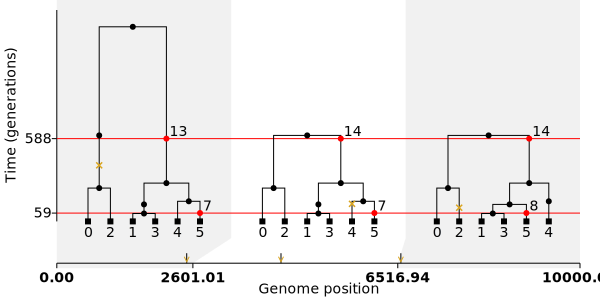

In [3]:
# Plot the recombination nodes in red, with a horizontal line at the time of occurrence,
# and only label nodes that are samples or recombination nodes.
samples = set(ts_arg.samples())
re_nodes = set(nd.id for nd in ts_arg.nodes() if nd.flags & msprime.NODE_IS_RE_EVENT)
re_times = [int(nd.time) for nd in ts_arg.nodes() if nd.flags & msprime.NODE_IS_RE_EVENT]
style = ".y-axis .grid {stroke: #ff000033} .mut .sym {stroke: goldenrod}"
for u in re_nodes:
    style += f".n{u} > .sym {{fill: red}}"
ts_arg.draw_svg(
    size=(600, 300),
    y_axis=True,
    y_ticks=re_times,
    y_gridlines=True,
    style=style,
    mutation_labels={},
    node_labels={u: u for u in samples | re_nodes}
)

The location of the recombination nodes imply that the *recombination events*
happened ~588 and ~59 generations ago. The older one, at 588 generations, involved node
13 (to the left of position 2601.01) and node 14 (to the right). As well as narrowing
down the recombination event to a specific point in time, the position of these two
nodes tells us that the SPR to convert the first into the second tree
involves pruning the branch above samples 1, 3, 4, and 5 and regrafting it onto the
branch above samples 0 and 2, rather than the other way around. Note that this
particular recombination does not change the *topology* of the tree, but simply the
branch lengths.

The recombination event 59 generations ago involved nodes 7 and 8, with the crossover
ocurring at position 6516.94. The SPR operation which converts the middle tree into the
last one involves pruning the branch above sample node 5 and regrafting it onto the
branch above the common ancestor of 1 and 3. In this case, the recombination has led to
a change in topology, such that the closest relative of 5 is node 4 from positions 0
to 6516.94, but 1 and 3 from positions 6516.94 to 10,000.

::::{note}

Many ARG representations associate each recombination event with a single node rather
than two. It is possible to represent this in `tskit`, but in such an ARG, the
edge annotations do not contain enough information to calculate the standard
likelihood under the Hudson model (see {ref}`sec_args_likelihoods`).

:::{todo}

Explain in plain language why 2 RE nodes are needed to calculate the likelihood under the
Hudson CwR: see e.g. https://github.com/tskit-dev/msprime/issues/1942#issuecomment-1013718650

One suggested way to do this is to show how there is not enough information in a 1-RE-node
plot to fully recreate the 2-RE-node equivalent. I think this is because we lose
information about the order of breakpoints when multiple breakpoints occur in
the same region of hidden material.

Note also that this approach only applies to a model in which a single crossover occurs
per chromosome.

:::

::::

(sec_args_likelihoods)=

## Calculating likelihoods

Because the ARG above was generated under the standard Hudson model (e.g. neutral
evolution in a large population with unique recombination breakpoints along a continuous
genome), we can calculate its likelihood under that model, for a given recombination
rate and population size, using the {func}`msprime:msprime.log_arg_likelihood` method.
Note however, that the simulation was run with the default ploidy level of 2, so that the
{func}`msprime:msprime.sim_ancestry` method assumed the `population_size` parameter was
the *diploid* population size. The `log_arg_likelihood` method requires `Ne`, the haploid
population size, which is twice as large, so the likelihood is calculated as follows:

In [4]:
print(
    "Log likelihood of the genealogy under the Hudson model:",
    msprime.log_arg_likelihood(
        ts_arg,
        recombination_rate=parameters["recombination_rate"],
        Ne=parameters["population_size"] * 2  # Number of *haploid* genomes
    )
)

Log likelihood of the genealogy under the Hudson model: -93.57791165409245


It is worth noting that we fully simplify the tree above, we remove all the unary nodes
and therefore lose information about the timings of recombination and non-coalescent
common ancestry, but we still keep the local trees intact:

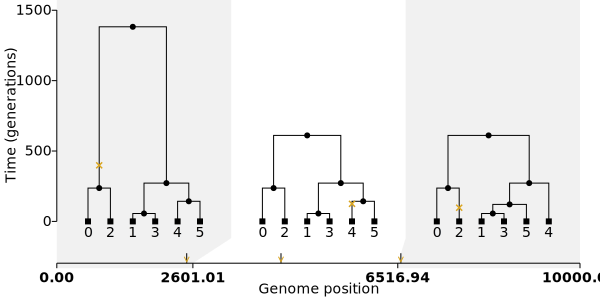

In [5]:
ts = ts_arg.simplify()
ts.draw_svg(
    size=(600, 300),
    y_axis=True,
    node_labels={u: u for u in ts.samples()},
    mutation_labels={},
    style=".mut .sym {stroke: goldenrod}",
    y_ticks=[t*500 for t in range(4)]
)

Because of this loss of information, the ARG likelihood cannot be calculated from the
simplified tree sequence. We can still, however, calculate the *mutation likelihood*
(i.e. the likelihood of the observed pattern of mutations, given the genealogy) because
the topology and branch lengths of the local trees remain unchanged after simplification:

In [6]:
print("Log likelihood of mutations given the genealogy:")
print(' "full" ARG:',  msprime.log_mutation_likelihood(ts_arg, mutation_rate=mu))
print(" simplified:", msprime.log_mutation_likelihood(ts, mutation_rate=mu))

Log likelihood of mutations given the genealogy:
 "full" ARG: -33.204860594400216
 simplified: -33.204860594400216


## Recording all nodes is expensive

Many extra nodes are required to store full information about ancestrally relevant
recombination. In fact, as the sequence length increases, these non-coalescent nodes come
to dominate the tree sequence (which is one reason they are not included by default).
We can calculate the percentage of non-coalescent nodes by comparing a full ARG with
its simplified version:

In [7]:
large_sim_parameters = parameters.copy()
large_sim_parameters["sequence_length"] *= 1000
ts_arg = msprime.sim_ancestry(**large_sim_parameters, record_full_arg=True)
ts = ts_arg.simplify()

print(
    "Non-coalescent nodes take up "
    f"{(1-ts.num_nodes/ts_arg.num_nodes) * 100:0.2f}% "
    f"of this {ts.sequence_length/1e6:g} megabase {ts.num_samples}-tip ARG"
)

Non-coalescent nodes take up 99.32% of this 10 megabase 6-tip ARG


This is one of the primary reasons that nodes which are never associated with coalescent
events are excluded by default in simulation software such as
[msprime](https://tskit.dev/software/msprime.html) and
[SLiM](https://tskit.dev/software/SLiM.html).

:::{note}
As well as ancestrally relevant nodes, the original (mathematical) ARG formulation by
[Griffiths (1991)](https://www.jstor.org/stable/4355649) includes recombination
nodes that are not ancestral to the samples. This leads to a graph with an
vastly larger number of nodes than even the ARGs simulated here, and using such
structures for simulation or inference is therefore infeasible.
:::

## Working with the ARG

:::{todo}
Add extra content as per [https://github.com/tskit-dev/tutorials/issues/43](https://github.com/tskit-dev/tutorials/issues/43)
:::

## Other software

:::{todo}
Show how ARGweaver output can be converted to tskit form.
:::

:::{todo}
Show how KwARG output can be converted to tskit form.
:::

:::{todo}
Implement conversion between the 2 RE node version and the 1 RE node version
:::